-> Objective - Programmatically segment the number plates from the video, and use OCR to arrive at the top 5 possible outputs from highest accuracy to the lowest

-> Make a 3 slide presentation to show your output. Slide 1 must have your overall approach. Slide 2 must have the segmentation method used and output screenshot. Slide 3 must have the OCR method used and screenshot.

In [1]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
from local_utils import detect_lp
from os.path import splitext,basename
from keras.models import model_from_json
import glob
import imutils
import pytesseract
import math
import numpy as np

In [2]:
capture_images = False
frames_path = r'C:\Users\Batman\GitPublic\KS_Img_seg_OCR\vid3_Frames'
image_paths = glob.glob("vid3_Frames/*.jpg")
print("Found %i images..."%(len(image_paths)))

if capture_images:
  cap = cv2.VideoCapture('vid3.mp4')

  # Check if camera opened successfully
  if (cap.isOpened()== False): 
    print("Error opening video stream or file")

  # Read until video is completed
  i=0

  while(cap.isOpened()):
    # Capture frame-by-frame
    ret, frame = cap.read()
    if ret == True:
      # Display the resulting frame
      cv2.imwrite(os.path.join(frames_path, 'Frame'+str(i)+'.jpg'), frame)
      i += 1
    # Break the loop
    else: 
      break
  # When everything done, release the video capture object
  cap.release()

Found 1207 images...


In [3]:
trial_frame = 'Frame255.jpg'
frames_path = r'C:\Users\Batman\GitPublic\KS_Img_seg_OCR'

car_plate = cv2.imread(os.path.join(frames_path,trial_frame))
print(car_plate.shape)

cv2.imshow('car plate',car_plate)
cv2.waitKey(0) # use this or kernel crashes
cv2.destroyAllWindows() 

(1080, 1920, 3)


In [4]:
cropped_img = car_plate[200:950,170:1560]
cv2.imshow('car plate',cropped_img)
cv2.waitKey(0) # use this or kernel crashes
cv2.destroyAllWindows() 

In [5]:
gray_img = cv2.cvtColor(car_plate, cv2.COLOR_BGR2GRAY)
thresh_img = cv2.threshold(gray_img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]

cnts = cv2.findContours(thresh_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if len(cnts) == 2 else cnts[1]
for cnt in cnts:
    approx = cv2.contourArea(cnt)

cv2.imshow('image', car_plate)
cv2.imshow('Binary',thresh_img)
cv2.waitKey()
cv2.destroyAllWindows() 

In [6]:
# Try to recognize the plate using WPOD - pretrained weights
def load_model(path):
    try:
        path = splitext(path)[0]
        with open('%s.json' % path, 'r') as json_file:
            model_json = json_file.read()
        model = model_from_json(model_json, custom_objects={})
        model.load_weights('%s.h5' % path)
        print("Loading model successfully...")
        return model
    except Exception as e:
        print(e)
wpod_net_path = "wpod-net.json"
wpod_net = load_model(wpod_net_path)

Loading model successfully...


Detect 1 plate(s) in Frame588
Coordinate of plate(s) in image: 
 [array([[460.28098465, 502.55965171, 494.05342883, 451.77476177],
       [464.77951275, 490.25512968, 522.0958357 , 496.62021877],
       [  1.        ,   1.        ,   1.        ,   1.        ]])]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


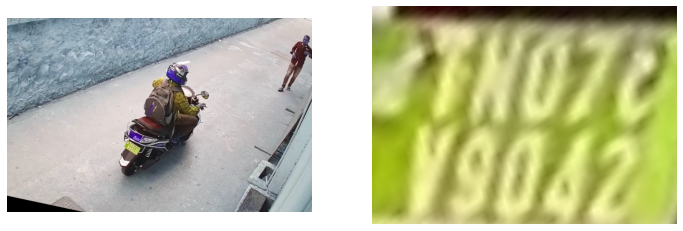

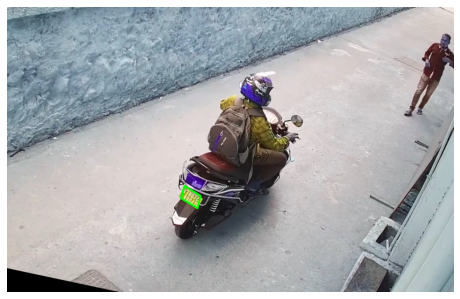

In [44]:
# Pass Image through model
def draw_box(image_path, cor, thickness=3): 
    pts=[]  
    x_coordinates=cor[0][0]
    y_coordinates=cor[0][1]
    # store the top-left, top-right, bottom-left, bottom-right 
    # of the plate license respectively
    for i in range(4):
        pts.append([int(x_coordinates[i]),int(y_coordinates[i])])
    
    pts = np.array(pts, np.int32)
    pts = pts.reshape((-1,1,2))
    vehicle_image = preprocess_image(image_path)
    
    cv2.polylines(vehicle_image,[pts],True,(0,255,0),thickness)
    return vehicle_image

def preprocess_image(image_path,resize=False):
    img = cv2.imread(image_path)
    # img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = imutils.rotate_bound(img, 12)
    img = img[480:1220,480:1640]
    img = img / 255
    if resize:
        img = cv2.resize(img, (224*3,224*3))
    return img

def get_plate(image_path, Dmax=608, Dmin=256):
    vehicle = preprocess_image(image_path)
    cv2.imshow('veh',vehicle)
    cv2.waitKey()
    cv2.destroyAllWindows() 
    ratio = float(max(vehicle.shape[:2])) / min(vehicle.shape[:2])
    side = int(ratio * Dmin)
    bound_dim = min(side, Dmax)
    _ , LpImg, _, cor = detect_lp(wpod_net, vehicle, bound_dim, lp_threshold=0.5)
    return LpImg, cor

test_image = r'vid3_Frames/Frame588.jpg' # image_paths[750] #381
LpImg,cor = get_plate(test_image)
print("Detect %i plate(s) in"%len(LpImg),splitext(basename(test_image))[0])
print("Coordinate of plate(s) in image: \n", cor)

# Visualize our result
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.axis(False)
plt.imshow(preprocess_image(test_image))
plt.subplot(1,2,2)
plt.axis(False)
plt.imshow(LpImg[0])

plt.figure(figsize=(8,8))
plt.axis(False)
plt.imshow(draw_box(test_image,cor))

[  0 255]


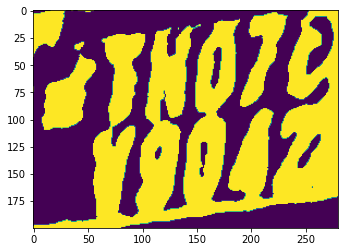

In [42]:
number_plate = (LpImg[0])*255
cv2.imwrite("number_plate.jpg",number_plate)

number_plate = cv2.imread('number_plate.jpg')
# number_plate.astype("uint8")
gray_img = cv2.cvtColor(number_plate, cv2.COLOR_BGR2GRAY)
thresh_img = cv2.threshold(gray_img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
plt.figure()
plt.imshow(thresh_img)

print(np.unique(thresh_img))

In [46]:

# get grayscale image
gray_img = cv2.cvtColor(number_plate, cv2.COLOR_BGR2GRAY)
thresh_img = cv2.threshold(gray_img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]


pytesseract.pytesseract.tesseract_cmd = r"C:\Program Files\Tesseract-OCR\tesseract.exe"
custom_config = r'--oem 3 --psm 1'
tess = pytesseract.image_to_data(thresh_img, config=custom_config)
print(tess)


level	page_num	block_num	par_num	line_num	word_num	left	top	width	height	conf	text
1	1	0	0	0	0	0	0	280	200	-1	

